In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
root = '/content/drive/MyDrive/Colab Notebooks/ViVIT/'

In [3]:
!pip install numpy
!pip install pandas
!pip install decord
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install pytorch-lightning
!pip install pytorchvideo
!pip install scikit-learn
!pip install scikit-multilearn
!pip install segmentation-models-pytorch
!pip install transformers

!pip install einops
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 50.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu117
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl

from einops import rearrange
from decord import VideoReader
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch.losses import FocalLoss
from transformers import AutoModel, AutoImageProcessor, AutoConfig
from skmultilearn.model_selection import iterative_train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorchvideo.transforms.transforms_factory import create_video_transform

from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device("cuda")          
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f'We will use the GPU: {torch.cuda.get_device_name(0)}')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Apollo optimizer and sampler

In [5]:
from torch.optim.optimizer import Optimizer


class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate
            beta (float, optional): coefficient used for computing running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve numerical stability (default: 1e-4)
            rebound (str, optional): recified bound for diagonal hessian:
                ``'constant'`` | ``'belief'`` (default: None)
            warmup (int, optional): number of warmup steps (default: 500)
            init_lr (float, optional): initial learning rate for warmup (default: lr/1000)
            weight_decay (float, optional): weight decay coefficient (default: 0)
            weight_decay_type (str, optional): type of weight decay:
                ``'L2'`` | ``'decoupled'`` | ``'stable'`` (default: 'L2')
        """

    def __init__(self, params, lr, beta=0.9, eps=1e-4, rebound='constant', warmup=500, init_lr=None, weight_decay=0, weight_decay_type=None):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(beta))
        if rebound not in ['constant', 'belief']:
            raise ValueError("Invalid recitifed bound: {}".format(rebound))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if init_lr is None:
            init_lr = lr / 1000
        if not 0.0 <= init_lr <= lr:
            raise ValueError("Invalid initial learning rate: {}".format(init_lr))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if weight_decay_type is None:
            weight_decay_type = 'L2' if rebound == 'constant' else 'decoupled'
        if weight_decay_type not in ['L2', 'decoupled', 'stable']:
            raise ValueError("Invalid weight decay type: {}".format(weight_decay_type))

        defaults = dict(lr=lr, beta=beta, eps=eps, rebound=rebound,
                        warmup=warmup, init_lr=init_lr, base_lr=lr,
                        weight_decay=weight_decay, weight_decay_type=weight_decay_type)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state['step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0 and group['weight_decay_type'] == 'L2':
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                eps = group['eps']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta ** state['step']
                alpha = (1 - beta) / bias_correction

                # calc the diff grad
                delta_grad = grad - exp_avg_grad
                if group['rebound'] == 'belief':
                    rebound = delta_grad.norm(p=np.inf)
                else:
                    rebound = 0.01
                    eps = eps / rebound

                # Update the running average grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(eps)
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(-alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                if group['rebound'] == 'belief':
                    denom = torch.max(B.abs(), rebound).add_(eps / alpha)
                else:
                    denom = B.abs().clamp_(min=rebound)

                d_p.copy_(exp_avg_grad.div(denom))

                # Perform step weight decay
                if group['weight_decay'] != 0 and group['weight_decay_type'] != 'L2':
                    if group['weight_decay_type'] == 'stable':
                        weight_decay = group['weight_decay'] / denom.mean().item()
                    else:
                        weight_decay = group['weight_decay']
                    d_p.add_(p, alpha=weight_decay)

                p.add_(d_p, alpha=-curr_lr)

        return 

In [6]:
#https://github.com/issamemari/pytorch-multilabel-balanced-sampler/blob/master/sampler.py
import random
import numpy as np

from torch.utils.data.sampler import Sampler


class MultilabelBalancedRandomSampler(Sampler):
    """
    MultilabelBalancedRandomSampler: Given a multilabel dataset of length n_samples and
    number of classes n_classes, samples from the data with equal probability per class
    effectively oversampling minority classes and undersampling majority classes at the
    same time. Note that using this sampler does not guarantee that the distribution of
    classes in the output samples will be uniform, since the dataset is multilabel and
    sampling is based on a single class. This does however guarantee that all classes
    will have at least batch_size / n_classes samples as batch_size approaches infinity
    """

    def __init__(self, labels, indices=None, class_choice="least_sampled"):
        """
        Parameters:
        -----------
            labels: a multi-hot encoding numpy array of shape (n_samples, n_classes)
            indices: an arbitrary-length 1-dimensional numpy array representing a list
            of indices to sample only from
            class_choice: a string indicating how class will be selected for every
            sample:
                "least_sampled": class with the least number of sampled labels so far
                "random": class is chosen uniformly at random
                "cycle": the sampler cycles through the classes sequentially
        """
        self.labels = labels
        self.indices = indices
        if self.indices is None:
            self.indices = range(len(labels))

        self.num_classes = self.labels.shape[1]

        # List of lists of example indices per class
        self.class_indices = []
        for class_ in range(self.num_classes):
            lst = np.where(self.labels[:, class_] == 1)[0]
            lst = lst[np.isin(lst, self.indices)]
            self.class_indices.append(lst)

        self.counts = [0] * self.num_classes

        assert class_choice in ["least_sampled", "random", "cycle"]
        self.class_choice = class_choice
        self.current_class = 0

    def __iter__(self):
        self.count = 0
        return self

    def __next__(self):
        if self.count >= len(self.indices):
            raise StopIteration
        self.count += 1
        return self.sample()

    def sample(self):
        class_ = self.get_class()
        class_indices = self.class_indices[class_]
        chosen_index = np.random.choice(class_indices)
        if self.class_choice == "least_sampled":
            for class_, indicator in enumerate(self.labels[chosen_index]):
                if indicator == 1:
                    self.counts[class_] += 1
        return chosen_index

    def get_class(self):
        if self.class_choice == "random":
            class_ = random.randint(0, self.labels.shape[1] - 1)
        elif self.class_choice == "cycle":
            class_ = self.current_class
            self.current_class = (self.current_class + 1) % self.labels.shape[1]
        elif self.class_choice == "least_sampled":
            min_count = self.counts[0]
            min_classes = [0]
            for class_ in range(1, self.num_classes):
                if self.counts[class_] < min_count:
                    min_count = self.counts[class_]
                    min_classes = [class_]
                if self.counts[class_] == min_count:
                    min_classes.append(class_)
            class_ = np.random.choice(min_classes)
        return class_

    def __len__(self):
        return len(self.indices)

# Main

In [7]:
root = '/content/drive/MyDrive/Colab Notebooks/ViVIT'
config = {
    "seed":2023,
    "model_name":"facebook/timesformer-base-finetuned-k400",
    "batch_size":6, # defualt 3
    "learning_rate":1e-5, # defualt 1e-5
    "data_dir":root+'/datasets',
    "checkpoint_dir":root+'/checkpoint',
    "submission_dir":root+'/submission',
}
weather = False
num_labels = 4
config["num_labels"] = num_labels

if num_labels == 2:
    config["n_classes"] = (2,3)
    config["label_dict"] = {
            -1:[-1,-1],
            0:[0,0],
            1:[1,1],
            2:[1,1],
            3:[1,1],
            4:[1,1],
            5:[1,1],
            6:[1,1],
            7:[1,2],
            8:[1,2],
            9:[1,2],
            10:[1,2],
            11:[1,2],
            12:[1,2]
        }
    config["label_reverse_dict"] = {
            (0,0):0,
            (1,1):1,
            (1,2):2,
        }

elif num_labels == 4:
    config["n_classes"] = (2,3,4,3)
    config["label_dict"] = {
            -1:[-1,-1,-1,-1],
            0:[0,0,0,0],
            1:[1,1,1,1],
            2:[1,1,1,2],
            3:[1,1,2,1],
            4:[1,1,2,2],
            5:[1,1,3,1],
            6:[1,1,3,2],
            7:[1,2,1,1],
            8:[1,2,1,2],
            9:[1,2,2,1],
            10:[1,2,2,2],
            11:[1,2,3,1],
            12:[1,2,3,2]
        }
    config["label_reverse_dict"] = {
            (0,0,0,0):0,
            (1,1,1,1):1,
            (1,1,1,2):2,
            (1,1,2,1):3,
            (1,1,2,2):4,
            (1,1,3,1):5,
            (1,1,3,2):6,
            (1,2,1,1):7,
            (1,2,1,2):8,
            (1,2,2,1):9,
            (1,2,2,2):10,
            (1,2,3,1):11,
            (1,2,3,2):12,
        }

if num_labels == 2 and weather:
    config["n_classes"] = (4,3)
    config["label_dict"] = {
            -1:[-1,-1],
            0:[0,0],
            1:[1,1],
            2:[1,2],
            3:[2,1],
            4:[2,2],
            5:[3,1],
            6:[3,2],
            7:[1,1],
            8:[1,2],
            9:[2,1],
            10:[2,2],
            11:[3,1],
            12:[3,2]
        }
    config["label_reverse_dict"] = {
            (0,0):0,
            (1,1):1,
            (1,2):2,
            (2,1):3,
            (2,2):4,
            (3,1):5,
            (3,2):6,
            (1,1):7,
            (1,2):8,
            (2,1):9,
            (2,2):10,
            (3,1):11,
            (3,2):12
            
        }
pl.seed_everything(config['seed'])

INFO:lightning_fabric.utilities.seed:Global seed set to 2023


2023

In [8]:
train_df = pd.read_csv(f"{config['data_dir']}/train.csv")
test_df = pd.read_csv(f"{config['data_dir']}/test.csv")

train_df['sample_id'] = train_df['sample_id'].apply(lambda x: int(x.split('_')[1]))
test_df['sample_id'] = test_df['sample_id'].apply(lambda x: int(x.split('_')[1]))

train_df['video_path'] = train_df['video_path'].apply(lambda x: config['data_dir'] + x[1:])
test_df['video_path'] = test_df['video_path'].apply(lambda x: config['data_dir'] + x[1:])

test_df['label']=-1
test_df['label_split'] = test_df['label'].apply(config['label_dict'].get)


train_df['label_split'] = train_df['label'].apply(config['label_dict'].get)
train_label_split = np.array(train_df['label_split'].tolist())

train_label_multi_hot = np.hstack([np.eye(n_class, dtype=np.int32)[train_label_split[:,idx]] for idx, n_class in enumerate(config['n_classes'])])
train_df['label_multi_hot'] = train_label_multi_hot.tolist()

if num_labels == 2:
    train_df['label'] = [x[1] for x in train_df['label_split']]
    test_df['label']= [x[1] for x in test_df['label_split']]

train_df_for_dataset, _ , val_df_for_dataset, _  = iterative_train_test_split(X=train_df.values, y=train_label_multi_hot, test_size=0.2)
test_df_for_dataset = test_df.values

train_multi_hot_for_sampler = np.array(train_df_for_dataset[:,4].tolist())

In [9]:
class VideoDataset(Dataset):
    def __init__(self, df_for_dataset, transform=None):
        self.sample_id = df_for_dataset[:,0]
        self.video_path = df_for_dataset[:,1]
        self.label = df_for_dataset[:,2]
        self.label_split = np.array(df_for_dataset[:,3].tolist())
        self.transform = transform
        self.top = 100

    def __len__(self):
        return len(self.sample_id)

    def __getitem__(self, idx):
        sample_id = self.sample_id[idx]
        video_path = self.video_path[idx]
        vr = VideoReader(video_path)
        video = torch.from_numpy(vr.get_batch(range(26,50,3)).asnumpy())[:,self.top:720-self.top,:,:]
        video = rearrange(video, 't h w c -> c t h w')
        label = self.label[idx]
        label_split = self.label_split[idx]
        

        if self.transform:
            video = self.transform(video)
        elif self.transform==None:
            video = torchvision.transforms.ConvertImageDtype(torch.float32)(video)
            video = torchvision.transforms.Resize([224,224])(video)

            video = video.permute(1, 0, 2, 3)  # C T H W to T C H W
            video = torchvision.transforms.Normalize(mean=[0.3493, 0.3485, 0.3497], std=[0.2093, 0.2132, 0.2103])(video)
            video = video.permute(1, 0, 2, 3)  # T C H W to C T H W
            
        video = rearrange(video, 'c t h w -> t c h w')


        sample = {
            'sample_id':sample_id,
            'video':video,
            'label':label,
            'label_split':label_split
        }
        
        return sample

model_config = AutoConfig.from_pretrained(config['model_name'])
image_processor_config = AutoImageProcessor.from_pretrained(config['model_name'])

train_transform = create_video_transform(
    mode='train',
    num_samples=model_config.num_frames,
    video_mean = tuple(image_processor_config.image_mean),
    video_std = tuple(image_processor_config.image_std),
    crop_size = tuple(image_processor_config.crop_size.values())
)

val_transform = create_video_transform(
    mode='val',
    num_samples=model_config.num_frames,
    video_mean = tuple(image_processor_config.image_mean),
    video_std = tuple(image_processor_config.image_std),
    crop_size = tuple(image_processor_config.crop_size.values())
)


train_dataset = VideoDataset(train_df_for_dataset, transform=None)
val_dataset = VideoDataset(val_df_for_dataset, transform=None)
test_dataset = VideoDataset(test_df_for_dataset, transform=None)

train_sampler = MultilabelBalancedRandomSampler(train_multi_hot_for_sampler)
train_dataloader = DataLoader(train_dataset, batch_size= config['batch_size'], sampler=train_sampler)
val_dataloader = DataLoader(val_dataset, batch_size = config['batch_size']*2)
test_dataloader = DataLoader(test_dataset, batch_size = config['batch_size']*2)

sample_id torch.Size([6])
video torch.Size([6, 8, 3, 224, 224])
label torch.Size([6])
label_split torch.Size([6, 4])


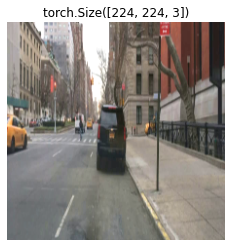

In [10]:
import matplotlib.pyplot as plt

def show_tensor(tensor):
    import torchvision.transforms as transforms
    mean = [0.45, 0.45, 0.45]
    std = [0.225, 0.225, 0.225]

# Define the denormalization transform
    denormalize = transforms.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )
    
    if len(tensor.shape) == 3:
        sample = denormalize(tensor).permute(1,2,0)
    elif len(tensor.shape) == 4:
        sample = denormalize(tensor[0]).permute(1,2,0)
    elif len(tensor.shape) == 5:
        sample = denormalize(tensor[0][0]).permute(1,2,0)
    
    plt.axis('off')
    plt.title(sample.shape)
    plt.imshow(sample)
    return sample

for video in train_dataloader:
    for key in video.keys():
        print(key, video[key].shape)
    break
a = show_tensor(video['video'])


In [11]:
print(video['label'], video['label_split'])

tensor([ 0,  1,  8, 12,  9,  0]) tensor([[0, 0, 0, 0],
        [1, 1, 1, 1],
        [1, 2, 1, 2],
        [1, 2, 3, 2],
        [1, 2, 2, 1],
        [0, 0, 0, 0]])


In [12]:
class PLVideoModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.learning_rate = config['learning_rate']
        self.model = AutoModel.from_pretrained(config['model_name'])
        self.classifiers = nn.ModuleList([
            nn.LazyLinear(n_class) for n_class in config['n_classes']
        ])
        self.loss = FocalLoss('multiclass')

    def forward(self, x):
        x = self.model(x).last_hidden_state.mean(dim=1)
        x_out = [classifier(x) for classifier in self.classifiers]
        return x_out

    def training_step(self, batch, batch_idx):
        video, label, label_split = batch['video'], batch['label'], batch['label_split']
        y_hats = self.forward(batch["video"])
        loss = sum([self.loss(y_hats[i], batch["label_split"][:,i]) for i in range(len(self.config['n_classes']))])
        loss = loss/len(self.config['n_classes'])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        video, label, label_split = batch['video'], batch['label'], batch['label_split']
        y_hats = self.forward(batch["video"])
        step_output = [*y_hats, label]
        return step_output
    
    def predict_step(self, batch, batch_idx):
        video, _, _ = batch['video'], batch['label'], batch['label_split']
        y_hats = self.forward(batch["video"])
        step_output = y_hats
        return step_output

    def validation_epoch_end(self, step_outputs):
        if self.config['num_labels'] == 2:
            pred1, pred2, label = [], [], []
            for step_output in step_outputs:
                pred1.append(step_output[0])
                pred2.append(step_output[1])
                label.append(step_output[2])

            pred1 = torch.cat(pred1).argmax(1)
            pred2 = torch.cat(pred2).argmax(1)
            label = torch.cat(label).tolist()

            pred = torch.stack([pred1,pred2],dim=1).cpu().detach().numpy().tolist()
            pred = list(map(lambda x: self.config['label_reverse_dict'].get(tuple(x),0),pred))
            
            score = f1_score(label,pred, average='macro')
            self.log("val_score", score)
            return score

        elif self.config['num_labels'] == 4:
            pred1, pred2, pred3, pred4, label = [], [], [], [], []
            for step_output in step_outputs:
                pred1.append(step_output[0])
                pred2.append(step_output[1])
                pred3.append(step_output[2])
                pred4.append(step_output[3])
                label.append(step_output[4])
        

            pred1 = torch.cat(pred1).argmax(1)
            pred2 = torch.cat(pred2).argmax(1)
            pred3 = torch.cat(pred3).argmax(1)
            pred4 = torch.cat(pred4).argmax(1)
            label = torch.cat(label).tolist()

            pred = torch.stack([pred1,pred2,pred3,pred4],dim=1).cpu().detach().numpy().tolist()
            pred = list(map(lambda x: self.config['label_reverse_dict'].get(tuple(x),0),pred))
            
            score = f1_score(label,pred, average='macro')
            self.log("val_score", score)
            return score
        
        
    
    def post_preproc(self, step_outputs):
        if self.config['num_labels'] == 2:
            pred1, pred2 = [], []
            for step_output in step_outputs:
                pred1.append(step_output[0])
                pred2.append(step_output[1])
                
            pred1 = torch.cat(pred1).argmax(1)
            pred2 = torch.cat(pred2).argmax(1)

            pred = torch.stack([pred1,pred2],dim=1).cpu().detach().numpy().tolist()
            pred = list(map(lambda x: self.config['label_reverse_dict'].get(tuple(x),0),pred))

            return pred
        elif self.config['num_labels'] == 4:
            pred1, pred2, pred3, pred4 = [], [], [], []
            for step_output in step_outputs:
                pred1.append(step_output[0])
                pred2.append(step_output[1])
                pred3.append(step_output[2])
                pred4.append(step_output[3])
                
            pred1 = torch.cat(pred1).argmax(1)
            pred2 = torch.cat(pred2).argmax(1)
            pred3 = torch.cat(pred3).argmax(1)
            pred4 = torch.cat(pred4).argmax(1)

            pred = torch.stack([pred1,pred2,pred3,pred4],dim=1).cpu().detach().numpy().tolist()
            pred = list(map(lambda x: self.config['label_reverse_dict'].get(tuple(x),0),pred))

            return pred
            
    def configure_optimizers(self):
        # def func(epoch):
        #     if epoch < 8:
        #         return 1e-5
        #     elif epoch < 13:
        #         return 1e-6
        #     else:
        #         return 1e-7
            
        optimizer = Apollo(self.parameters(), lr=self.learning_rate)
        #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch : 0.9 ** epoch)

        # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        #     optimizer=optimizer,
        #     T_0=16,
        #     eta_min = 1e-8,
        #     T_up=1,
        #     gamma=0.3,
        #     last_epoch = 100,
        # )

        return [optimizer]

In [ ]:

for seed in [1,2,3,4,5,6,7,8,9,10]:
    config['seed'] = seed
    pl.seed_everything(config['seed'])
    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_score',
        dirpath=config['checkpoint_dir'],
        filename=f'{config["model_name"]}'+'-{epoch:02d}-{train_loss:.4f}-{val_score:.4f}'+f'_seed{config["seed"]}',
        mode='max'
    )

    early_stop_callback = EarlyStopping(
        monitor="train_loss",
        patience=4,
        verbose=False,
        mode="min"
    )

    pl_video_model = PLVideoModel(config)
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='auto',
        precision=16,
        num_sanity_val_steps=0,
        callbacks=[early_stop_callback, checkpoint_callback]
    )

    trainer.fit(pl_video_model, train_dataloader, val_dataloader)
    pl_video_model.eval()

    pred = trainer.predict(pl_video_model, test_dataloader)
    pred_post_proc = pl_video_model.post_preproc(pred)
    submit = pd.read_csv(f"{config['data_dir']}/sample_submission.csv")
    submit['label'] = pred_post_proc
    submit.to_csv(f"{config['submission_dir']}/seed{config['seed']}_patient4_4_crop.csv", index=False)

INFO:lightning_fabric.utilities.seed:Global seed set to 1


Some weights of the model checkpoint at facebook/timesformer-base-finetuned-k400 were not used when initializing TimesformerModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TimesformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimesformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 360it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 2
Some weights of the model checkpoint at facebook/timesformer-base-finetuned-k400 were not used when initializing TimesformerModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TimesformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimesformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:pytorch_lightning.util

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 360it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 3
Some weights of the model checkpoint at facebook/timesformer-base-finetuned-k400 were not used when initializing TimesformerModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TimesformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TimesformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:pytorch_lightning.util

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
pl_video_model.eval()

pred = trainer.predict(pl_video_model, test_dataloader)
pred_post_proc = pl_video_model.post_preproc(pred)
submit = pd.read_csv(f"{config['data_dir']}/sample_submission.csv")
submit['label'] = pred_post_proc
submit.to_csv(f"{config['submission_dir']}/weatherday_lambdaLR_batch{batch_size}_patient8_4_crop.csv", index=False)

# 나머지

In [ ]:
pl_video_model.eval()

pred = trainer.predict(pl_video_model, val_dataloader)
pred_post_proc = pl_video_model.post_preproc(pred)

In [ ]:
# optimizer = Apollo(pl_video_model.parameters(), lr=0.001)
# PATH = root+"/checkpoint_bin/facebook/timesformer-base-finetuned-k400-epoch=07-train_loss=0.0045-val_score=0.5890.ckpt"
# checkpoint = torch.load(PATH, map_location='cpu')
# pl_video_model.load_state_dict(checkpoint['state_dict'])

# pl_video_model.eval()

# pred = trainer.predict(pl_video_model, test_dataloader)
# pred_post_proc = pl_video_model.post_preproc(pred)

In [ ]:
pred_post_proc = pl_video_model.post_preproc(pred)

In [ ]:
print(pred_post_proc)

In [ ]:
f1_score(pred_post_proc, list(val_dataset.label), average='macro')

In [ ]:
len(list(np.where(pred_post_proc == val_dataset.label)[0]))/len(pred_post_proc)